# Welcome to your 11th assignment!

Please submit your solution of this notebook in the Whiteboard at the corresponding Assignment entry. We need you to upload the .ipynb-file and the exported .pdf of this notebook.

If you have any questions, ask them in either in the tutorials or in the "Mattermost" channel: https://mattermost.imp.fu-berlin.de/biorobotics/channels/ssl_ws_2324


For the last assignment of the course, we want you to solve a small project working on data from the ***ElectroFish*** project.

Useful links: <br>
[Blogpost (1)](https://shchur.github.io/blog/2020/tpp1-conditional-intensity/)<br>
[Blogpost (2)](https://shchur.github.io/blog/2021/tpp2-neural-tpps/)<br>

# ElectroFish

## Short Description
The ElectroFish project is based around a fish species with an electric organ. The fish can emit electric impulses that are used for communication and navigation. One purpose of the experiments is to gain insight into the fish's social interactions.


## ElectroFish Assignment Goal
Using SSL, we want to learn a joint embedding of the fish's locomotory behaviour and the fish's EOD (Electric Organ Discharge) activity. <br> 
We want to use this embedding to create counterfactuals, i.e. we want to find neural activity that would lead to a certain behaviour and vice versa. <br>


## Data
You will find the data here: <br>
[gDrive](https://drive.google.com/drive/folders/11kz1BGG4qCm7uGdHDINltBo53fD_YvPD?usp=drive_link)

The data is structured as follows:

-> Mormyrus_Pair_xx <br>
&nbsp;&nbsp;&nbsp;&nbsp;-> 20230316_Mormyrus_Pair_xx.json.gz <br>
&nbsp;&nbsp;&nbsp;&nbsp;-> fish_ids <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> labels.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> labels.xlsx <br>
&nbsp;&nbsp;&nbsp;&nbsp;-> metadata <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> tank_annotations.json <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> video_meta.json <br>
&nbsp;&nbsp;&nbsp;&nbsp;-> poses <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> poses.h5 <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> poses.slp <br>
&nbsp;&nbsp;&nbsp;&nbsp;-> raw <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> 20230316_Mormyrus_Pair_xx.mp4 <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> 20230316_Mormyrus_Pair_xx.smr <br>

The **.json.gz** file contains the processed data used for training a location prediction model. We recommend checking this out first to get a nice overview. <br>
The **fish_ids** folder contains the manually labeled EOD signals. <br>
The **metadata** folder contains the metadata for the tank and video of the experiment. <br>
The **poses** folder contains the tracking data of the fish obtained with a [SLEAP](https://sleap.ai/) model. <br>
The **raw** folder contains the raw data of the experiment: .mp4 video recording and .smr continuous electrode data recodring. <br>

To get a nice overview of the data, we recommend checking out the **.json.gz** file and the **metadata**-folder first.<br>
Like mentioned before, the **.json.gz** file contains the processed data used for training a location prediction model. It contains data points for every eod event happening in the experiment. For our tasks, we recommend processing the full data yourself (.h5 or .slp file for full tracking data; .smr file for full electrode data), to not loose any information. <br>

The columns of the DataFrame provide you with a nice overview of the data:
- **time_stamp**: The time stamp of the EOD event in seconds
- **video_frame**: The video frame in which the EOD event occured
- **fish_id**: The ID of the fish that emitted the EOD event
    - manually labeled in Pair experiments with 1 being the bigger fish
- **pixel_tracks**: all SLEAP track in pixel coordinates of the given video_frame
    - The shape of the data [2,6,2] corresponds to [fish_id, bodypart_id, x/y coordinates]
    - The bodyparts: 
        - 0: head
        - 1: left_fin
        - 2: right_fin
        - 3: body_end
        - 4: back_fin
        - 5: middle
- **world_tracks**: all SLEAP tracks in world coordinates
- **tracking_scores**: 'confidence' score of SLEAP for all fish 
- **ced_electrode_data**: of the peak detected from the smr-data
    - EOD event sensor data
    - The shape of the data [4,70] corresponds to [elecrode_id, value window of size 70]
- **efi_electrode_data**: of the peak detected from the board-data
    - Different sensor for measurung EOD events
    - Shape [4,50]


## Milestones
To provide you with more detailed subtasks, we split the assignment into 3 milestones. Each milestone represents the workload of 1 week and should be submitted like an assignment sheet. Therefore, please use and submit this notebook in the Whiteboard at the corresponding Assignment entry. We need you to upload the .ipynb-file and the exported .pdf of this notebook. 

**Milestone 1** <br>
Done. <br>

**Milestone 2** <br>
*Goal*: Train an imiation model of the fish electrical behaviour. <br>
*Steps*: <br>
&nbsp;&nbsp;&nbsp;&nbsp;1) Preprossessing input and output data <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Inputs: [EOD signal] <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Output: [PDF parameters] <br>
&nbsp;&nbsp;&nbsp;&nbsp;2) Prepare DataLoader<br>
&nbsp;&nbsp;&nbsp;&nbsp;3) Train Imitation model for the EOD signal<br>
&nbsp;&nbsp;&nbsp;&nbsp;4) Visualization / Evaluation <br>

**Milestone 3** <br>
*TBC in 2 weeks, 06.02.24*


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import sys
from tqdm.notebook import tqdm

# Load processed EOD data
from fish_helper import DatasetContainer

In [2]:
# Getting an idea of the data. 
# (And maybe to determine the starting video frame of the eod data for future milestones)

data = DatasetContainer()
data.load(path='data/Mormyrus_Pair_01/dataset/20230316_Mormyrus_Pair_01.json.gz')

# Show meta data
print(data.meta)

# Show data
# data.data.info()
data.data.head(10)

/home/mi/manueh51/ssl_2324_assignments/fish_helper.py:59: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  self.data = pd.read_json(container_json['data'], dtype=dtype)


{'tank_corner_points': [[128.95050048828125, 1697.019775390625], [113.4000015258789, 280.3999938964844], [1831.026123046875, 279.8823547363281], [1831.59716796875, 1672.93994140625]], 'pixel_to_world_matrix': [[0.06644436292251645, -0.0007293721365335534, -7.330274914167141], [-0.0009595544796270599, -0.06784856731417248, 115.26409549446636], [-9.74359066112888e-06, -6.028094366956945e-06, 1.0]], 'world_to_pixel_matrix': [[14.893747708751922, -0.1715645723739672, 128.95050048828125], [0.03626900649996236, -14.720576310935625, 1697.019775390625], [0.0001453372084619642, -9.04086815969854e-05, 1.0]], 'tracks_minimum_score': 3.0, 'first_frame_of_sync': 136, 'time_of_video': 308.6, 'fps': 25, 'peak_left_offset': 35, 'peak_right_offset': 35, 'peak_prominence': 0.03, 'filter_plateau': True, 'min_plateau_size': 3, 'num_real_fish': 2, 'dtypes': {'time_stamp': 'float64', 'video_frame': 'int64', 'fish_id': 'Int64', 'pixel_tracks': 'object', 'world_tracks': 'object', 'tracking_scores': 'object', 

,time_stamp,video_frame,fish_id,pixel_tracks,world_tracks,tracking_scores,ced_electrode_data,efi_electrode_data
0,0.01120,136,1,"[[[1637.6125488281, 1552.1987304688], [1686.54...","[[[102.9537891214, 8.5958438126], [106.3467447...","[4.6689133644, 4.9788632393]","[[1.8263244629000002, 1.8272399902, 1.82739257...","[[285, 299, 280, 333, 283, 261, 184, 252, 93, ..."
1,0.02490,137,2,"[[[1627.2991943359, 1553.25], [1681.615234375,...","[[[102.2400654784, 8.5319933544], [106.0039933...","[4.7536907196, 4.8814210892]","[[1.8272399902, 1.8278503418, 1.8267822266, 1....","[[327, 354, 319, 323, 357, 424, 294, 409, 419,..."
2,0.06948,138,1,"[[[1616.6354980469, 1557.095703125], [1676.027...","[[[101.5019092768, 8.2741293738], [105.6156216...","[4.6453266144, 4.9770188332]","[[1.8240356444999999, 1.8254089355, 1.82205200...","[[359, 343, 399, 331, 350, 376, 346, 378, 260,..."
3,0.08270,138,2,"[[[1616.6354980469, 1557.095703125], [1676.027...","[[[101.5019092768, 8.2741293738], [105.6156216...","[4.6453266144, 4.9770188332]","[[1.8228149413999999, 1.8264770508, 1.82662963...","[[357, 423, 353, 366, 413, 469, 437, 478, 537,..."
4,0.13838,139,1,"[[[1606.1176757812, 1557.5185546875], [1674.60...","[[[100.7743917906, 8.2542062312], [105.5168695...","[4.479634285, 5.1406679153]","[[1.8197631836000001, 1.8228149413999999, 1.82...","[[301, 290, 318, 288, 314, 279, 258, 255, 154,..."
5,0.15188,140,2,"[[[1599.9650878906, 1558.1341552734], [1669.49...","[[[100.3488395774, 8.2169473611], [105.1628198...","[4.4004626274, 4.8763465881]","[[1.8260192871, 1.8212890625, 1.8229675293, 1....","[[374, 324, 459, 351, 407, 371, 387, 388, 480,..."
6,0.19700,141,2,"[[[1590.3410644531, 1562.8796386719], [1663.90...","[[[99.682780818, 7.8956671369], [104.775387448...","[4.092713356, 4.5360798836]","[[1.8270874023, 1.8240356444999999, 1.82586669...","[[275, 328, 296, 305, 290, 312, 268, 297, 239,..."
7,0.20324,141,1,"[[[1590.3410644531, 1562.8796386719], [1663.90...","[[[99.682780818, 7.8956671369], [104.775387448...","[4.092713356, 4.5360798836]","[[1.831817627, 1.8243408203, 1.8209838867, 1.8...","[[275, 328, 296, 305, 290, 312, 268, 297, 239,..."
8,0.23648,142,2,"[[[1584.3190917969, 1567.75], [1658.6987304688...","[[[99.2658024619, 7.5624747078], [104.41480335...","[4.2152342796, 3.9297819138000003]","[[1.8272399902, 1.8301391602, 1.8284606934, 1....","[[360, 336, 360, 390, 433, 362, 407, 401, 412,..."
9,0.27080,143,1,"[[[1579.3872070312, 1568.7956542969], [1649.35...","[[[98.9247250831, 7.4942501428], [103.76764361...","[4.2730569839, 3.4880776405000002]","[[1.8276977538999999, 1.8264770508, 1.82846069...","[[286, 387, 323, 305, 433, 358, 422, 429, 467,..."


In [3]:
# Electrode data sample
data.data["pixel_tracks"][0].shape

(2, 6, 2)

(5456, 4, 70)


<Axes: >

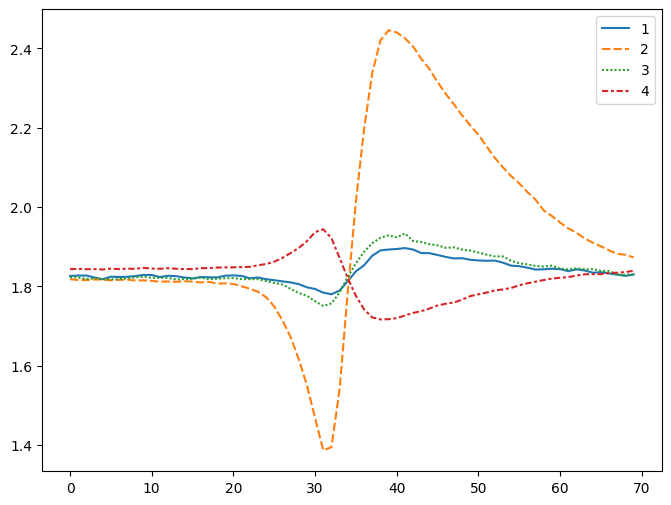

In [4]:
# Sample plot for electrode spike data
to_plot = np.stack(data.data.ced_electrode_data.loc[:].to_numpy())
print(to_plot.shape)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()

sns.lineplot(
    pd.DataFrame({
        '1': to_plot[0,0],
        '2': to_plot[0,1],
        '3': to_plot[0,2],
        '4': to_plot[0,3],
    }))

In [5]:
# Read .h5 or .slp file for full tracking data
# https://sleap.ai/tutorials/analysis.html
# https://sleap.ai/api/sleap.io.convert.html#module-sleap.io.convert

import h5py

with h5py.File('data/Mormyrus_Pair_01/poses/20230316_Mormyrus_Pair_01.000_20230316_Mormyrus_Pair_01.analysis.h5', 'r') as f:
    occupancy_matrix = f['track_occupancy'][:]
    tracks_matrix = f['tracks'][:]

print(occupancy_matrix.T.shape)
print(tracks_matrix.T.shape)

(2, 7715)
(7715, 6, 2, 2)


In [6]:
# Package for the raytracing for wall information
# https://git.imp.fu-berlin.de/bioroboticslab/robofish/fish_models/

# Raycast example usage
# https://git.imp.fu-berlin.de/bioroboticslab/robofish/fish_models/-/blob/dev_andi_train/examples/raycast_examples.ipynb

## Milestone 2
### Step 1 - Preprocess data

As a first step we want you to preprocess the input and output data to feed them into future models. <br>
The input data should be preprocessed (see [Blogpost](https://shchur.github.io/blog/2021/tpp2-neural-tpps/)) to feed it into an imitation model.<br>

Suggestions for the input data: <br>
**Input Vector**: [EOD signal] <br>
**Output Vector**: [Parameters for a Probability Density Function] <br>

In [ ]:
# Code here

### Step 2 - Prepare Dataloader

Set up the dataloader to train the autoregressive imitation model on. The labels should future events of the sequence. <br>

In [ ]:
# Code here

### Step 3 - Train Imitation model

Set up and train your imitation model on your dataloader.

In [ ]:
# Code here

### Step 4 - Visualization / Evaluation

Visualize the signal generated by your model. Evaluate the model's performance.

In [ ]:
# Code here